In [1]:
import sys
sys.path.append('../')

In [2]:
from pytorch_lightning import Trainer
from box import Box
import sys

from src.models import DCT
from src.data import TestDataModule

/home/wpzhang/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cfg = Box.from_yaml(open('../configs/test.yaml', "r").read())

model = DCT.load_from_checkpoint("../"+cfg.ckpt_path)
trainer = Trainer(accelerator=cfg.accelerator, devices=cfg.devices)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
model.use_seg = False
dm = TestDataModule(
    "../"+cfg.test_dir,
    model.l_bin,
    model.ab_bin,
    150,
    False,
    batch_size=1,
    num_workers=cfg.num_workers,
)
res = trainer.predict(model, dm)
out = []
for batch in res:
    out.extend(batch)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

/home/wpzhang/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [5]:
model.use_seg = True
dm = TestDataModule(
    "../"+cfg.test_dir,
    model.l_bin,
    model.ab_bin,
    150,
    True,
    batch_size=1,
    num_workers=cfg.num_workers,
)
res = trainer.predict(model, dm)
seg_out = []
for batch in res:
    seg_out.extend(batch)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


In [7]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from typing import List

In [8]:
def visualize_result(test_dir:Path, out:List["np.ndarray"], seg_out:List["np.ndarray"]):
    
    in_img_dir = test_dir / "in_imgs"
    ref_img_dir = test_dir / "ref_imgs"
    in_img_paths = sorted(list(in_img_dir.glob("**/*.jpg")))
    ref_img_paths = sorted(list(ref_img_dir.glob("**/*.jpg")))

    num_cols    = 4
    num_rows    = len(out)
    col_map = {0:'Input',1:'Reference',2:'Without seg',3:'With seg'}

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,5*num_rows))
    list_axes = list(axes.flat)

    for i in range(len(out)):
        list_axes[i*num_cols+0].imshow(Image.open(in_img_paths[i]))
        list_axes[i*num_cols+1].imshow(Image.open(ref_img_paths[i]))
        list_axes[i*num_cols+2].imshow(out[i])
        list_axes[i*num_cols+3].imshow(seg_out[i])
        if i == 0:
            for j in range(4):
                list_axes[j].set_title(col_map[j], fontsize=25) 

    for axi in axes.ravel():
        axi.set_axis_off()
    fig.tight_layout()
    _ = plt.show()

In [9]:
test_dir = Path("../"+cfg.test_dir)

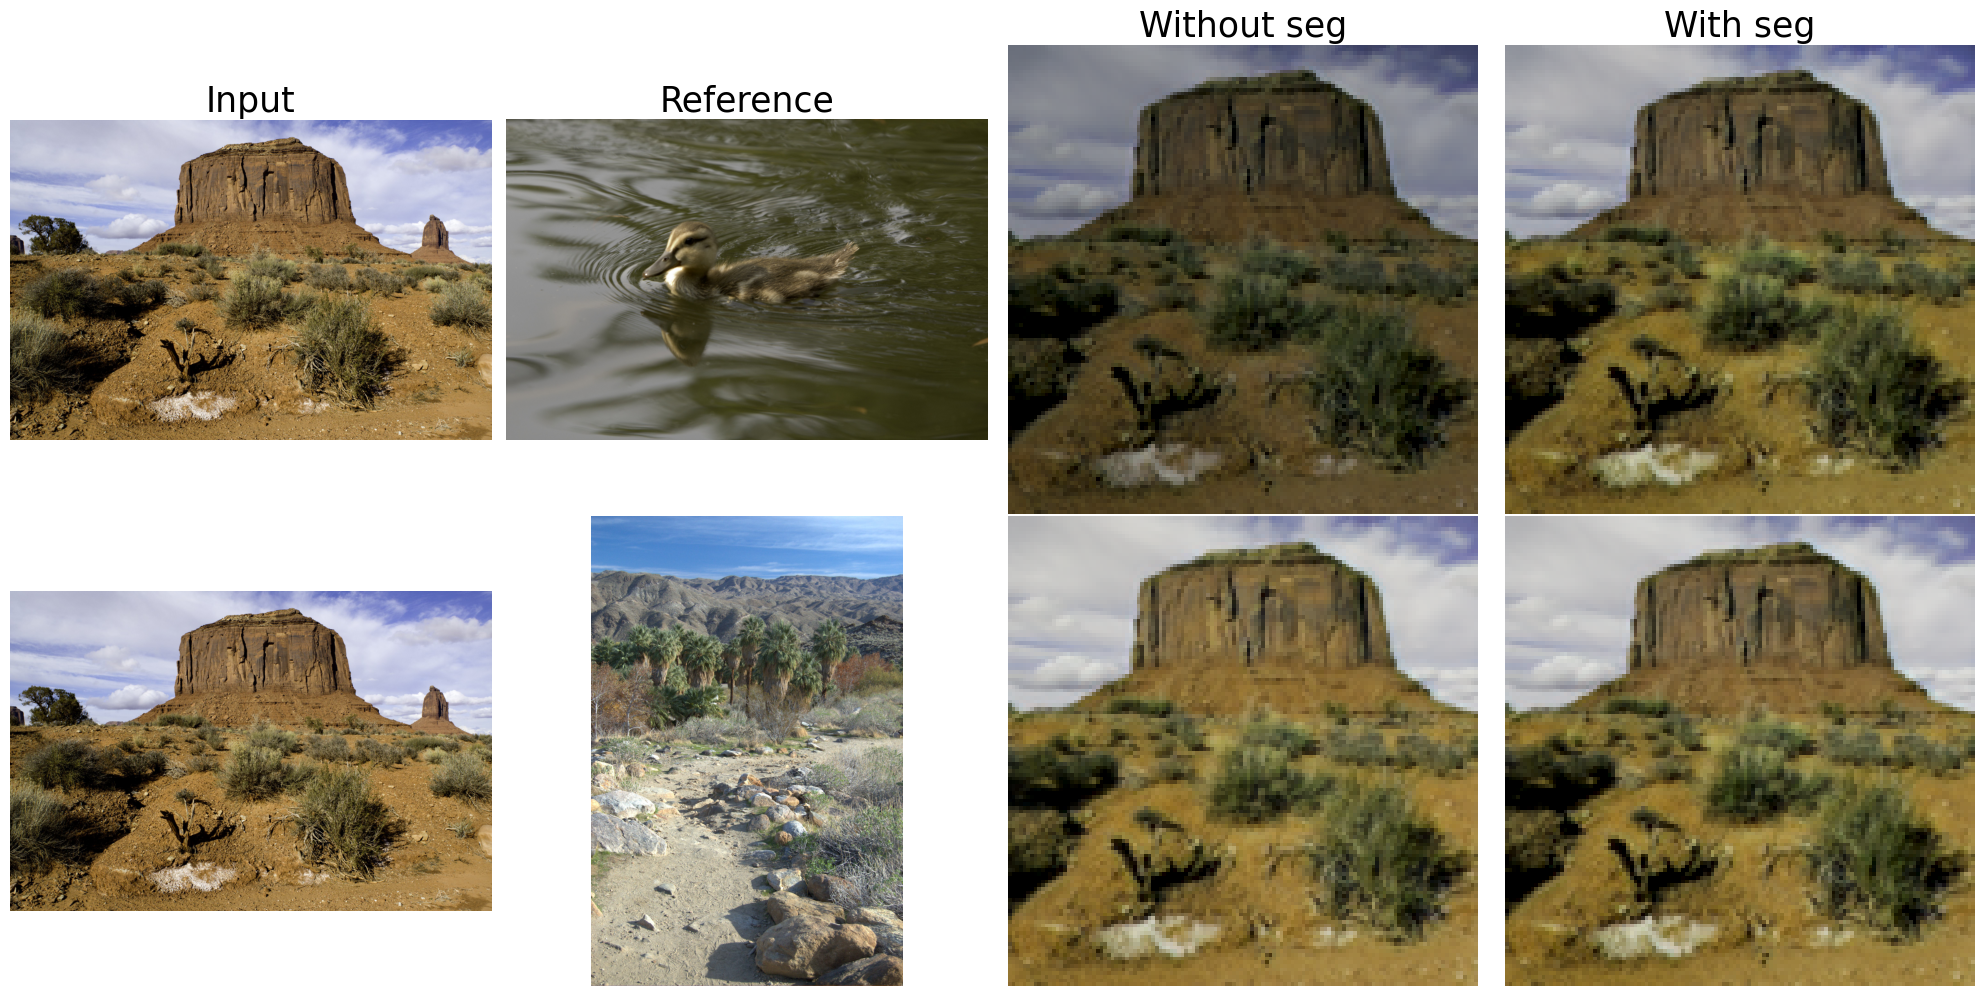

In [10]:
visualize_result(test_dir, out, seg_out)